In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1.values)
        X += list(self.train.P1_diff1.values)
        X += list(self.train.P1_diff2.values)
        X += list(self.train.P1_diff4.values)
        for feature in self.features:
            X.append(self.test[feature].values[forvard_time])
        return X
    
    def get_y(self, forward_time):
        y = self.test.P1.values[forward_time]
        return y

        
    def get_meta_X(self, forward_time, models):
        X = self.get_X(forward_time)
        model = models[forward_time]
        prediction = model.predict([X])[0]
        X_meta = [prediction]
        for feature in self.features:
            X_meta.append(self.test[feature].values[forward_time])
        return X_meta
        
        

In [5]:
def prepare_data(data):
    data['P1'] = data.P1.interpolate()
    data['pressure'] = data.pressure.interpolate()
    data['humidity'] = data.humidity.interpolate()
    data['temperature'] = data.temperature.interpolate()
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    #data['prec_amount'] = data.prec_amount//data.prec_time
    data['prec_time'] = data.prec_time.interpolate()
    data['prec_amount'] = data.prec_amount.interpolate()
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    return data

In [6]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

def add_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
    data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
    data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
    data['cos_hour'] = np.cos(2*np.pi*data.hour/24)
    data['P1_diff1'] = data.P1.diff(periods=1)
    data['P1_diff2'] = data.P1.diff(periods=2)
    data['P1_diff4'] = data.P1.diff(periods=4)
    data['wind_direction'] = data.wind_direction.map(wind_dir)
    data["wind_sin"] = np.sin(np.radians(data.wind_direction))
    data["wind_cos"] = np.cos(np.radians(data.wind_direction))
    data['wind_sin'] = data.wind_sin.fillna(value=2)
    data['wind_cos'] = data.wind_cos.fillna(value=2)
    return data

In [7]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [8]:
sel_columns = ['P1', 'pressure', 'temperature', 'humidity', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time']
data = data[sel_columns]

In [9]:
data = prepare_data(data)
data = add_features(data)
data = data.resample('1H').mean()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9001 entries, 2019-04-01 00:00:00+00:00 to 2020-04-10 00:00:00+00:00
Freq: H
Data columns (total 19 columns):
P1                9001 non-null float64
pressure          9001 non-null float64
temperature       9001 non-null float64
humidity          9001 non-null float64
wind_direction    7399 non-null float64
wind_speed        9001 non-null float64
prec_amount       9001 non-null float64
prec_time         9001 non-null float64
day_of_week       9001 non-null float64
hour              9001 non-null float64
sin_day           9001 non-null float64
cos_day           9001 non-null float64
sin_hour          9001 non-null float64
cos_hour          9001 non-null float64
P1_diff1          9001 non-null float64
P1_diff2          9001 non-null float64
P1_diff4          9001 non-null float64
wind_sin          9001 non-null float64
wind_cos          9001 non-null float64
dtypes: float64(19)
memory usage: 1.4 MB


In [11]:
train_data = data['2019-04-02 00:00:00+00:00':str(data.index[-1] - datetime.timedelta(days=50))]
test_data = data[str(data.index[-1] - datetime.timedelta(days=50)):]

In [12]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [13]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [14]:
chunk_len = 48
test_len = 24
train_start_idx = train_data.index[0]
train_end_idx = train_data.index[-1] - datetime.timedelta(hours=chunk_len)
train_num_samples = 2000
features = ['pressure', 'temperature', 'humidity', 'wind_speed', 'prec_amount',
           'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'wind_sin', 'wind_cos']
np.random.seed(42)

train_chunks = generate_chunks(train_data, train_num_samples,
                               train_start_idx, train_end_idx,
                               chunk_len, test_len, features)

test_start_idx = test_data.index[0]
test_end_idx = test_data.index[-1] - datetime.timedelta(hours=chunk_len)
test_num_samples = 300

test_chunks = generate_chunks(test_data, test_num_samples,
                              test_start_idx, test_end_idx,
                              chunk_len, test_len,
                              features)

In [15]:
train, train_meta = train_test_split(train_chunks, test_size=0.5, random_state=42)

In [16]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [17]:
def get_mae(models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [18]:
#mod = RandomForestRegressor(min_samples_leaf=3, random_state=42)
mod = Lasso(alpha=1.05, random_state=42)
models = train_models(mod, train, test_len)

In [19]:
mae = get_mae(models, test_chunks)

In [20]:
mae, np.mean(mae)

([1.3818686332306016,
  2.6767075418723976,
  3.7553854464867142,
  4.5314685777792345,
  5.210327519721985,
  5.627516226872461,
  5.9598537407713446,
  6.127353697892777,
  6.260514144787482,
  6.491897199008621,
  6.844095066527886,
  7.009613661408523,
  7.1011727250836065,
  7.0521771025069455,
  6.923589941894011,
  7.380104118142591,
  7.704966266512092,
  7.619836159141262,
  7.727598085560696,
  7.7109871350000105,
  8.062983537325495,
  8.088867058724714,
  8.914555323318188,
  9.22494414589755],
 6.474515960644466)

In [21]:
def train_meta_models(meta_model, models, chunks, num_models):
    meta_models = []
    for i in range(num_models):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = clone(meta_model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        meta_models.append(local_model)
    return meta_models

In [22]:
def get_meta_mae(models, meta_models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [23]:
%%time
#meta_model = Lasso(alpha=0.2, random_state=42)
#meta_model = Ridge(alpha=0.6, random_state=42)
meta_model = RandomForestRegressor(min_samples_leaf=55, random_state=42)
meta_models = train_meta_models(meta_model, models, train_meta, test_len)

CPU times: user 16 s, sys: 87.6 ms, total: 16 s
Wall time: 16.6 s


In [24]:
meta_mae = get_meta_mae(models, meta_models, test_chunks)

In [25]:
def get_feature_impotances(models):
    importance = models[0].feature_importances_
    for mod in models[1:]:
        local_importance = mod.feature_importances_
        importance += local_importance
    importance = importance / len(models)
    return list(importance)

In [26]:
get_feature_impotances(meta_models)

[0.9247034417341339,
 0.00783456934355325,
 0.014932364697490865,
 0.029626561741205596,
 0.0073020995316430025,
 7.65205622351443e-05,
 0.0007887511009632822,
 0.00015831545414380204,
 0.000839522583071841,
 0.0008800669824143228,
 0.010195904283911346,
 0.002661881985233615]

In [27]:
np.mean(meta_mae)

6.28144626311527

In [28]:
np.mean(meta_mae)

6.28144626311527

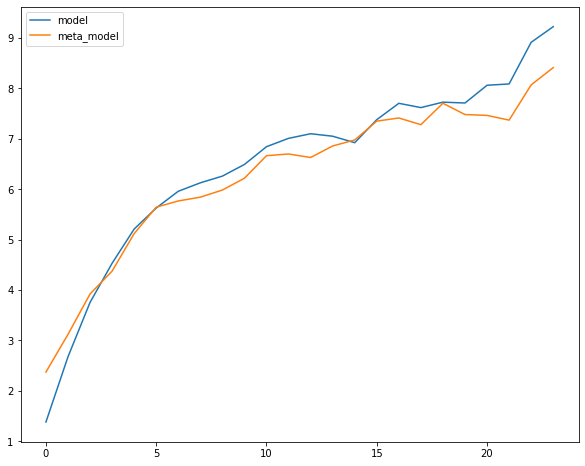

In [29]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()

In [30]:
mae, np.mean(mae)

([1.3818686332306016,
  2.6767075418723976,
  3.7553854464867142,
  4.5314685777792345,
  5.210327519721985,
  5.627516226872461,
  5.9598537407713446,
  6.127353697892777,
  6.260514144787482,
  6.491897199008621,
  6.844095066527886,
  7.009613661408523,
  7.1011727250836065,
  7.0521771025069455,
  6.923589941894011,
  7.380104118142591,
  7.704966266512092,
  7.619836159141262,
  7.727598085560696,
  7.7109871350000105,
  8.062983537325495,
  8.088867058724714,
  8.914555323318188,
  9.22494414589755],
 6.474515960644466)

In [31]:
meta_mae, np.mean(meta_mae)

([2.3733564382724026,
  3.1208942016987327,
  3.9222073885685784,
  4.37611463001654,
  5.119822346807143,
  5.644422165835232,
  5.76748984156587,
  5.843060699943573,
  5.984154804685341,
  6.2186906147206935,
  6.665550186096908,
  6.699587810904041,
  6.629527006143681,
  6.858386192523823,
  6.977595077949122,
  7.351539725949503,
  7.413703718693505,
  7.28137031186906,
  7.705714113180834,
  7.481967750686781,
  7.465079487057201,
  7.3714087303420275,
  8.070581004924962,
  8.412486066330926],
 6.28144626311527)